This notebook on Subset Selection is a Python adaptation of p. 244-247 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Adapted by R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016). Github: https://github.com/JWarmenhoven/ISLR-python

In [1]:
from linear_regression_modularized_functions import *

## Reading variables

In [2]:
# POSTCODE MAP OF NL
pc = gpd.read_file('../data/spatial-data/nl_pc4.shp')
pc = pc[['PC4', 'geometry']]
pc.rename(columns={'PC4': 'pc'}, inplace=True)
pc = pc.to_crs('EPSG:28992') # be sure to change crs to amersfoort! 

# LMA DF
lma = feather.read_dataframe('../data/lma/flows_ont-af_combined.feather')
lma = pd.merge(lma, pc, how='left', on='pc')
lma = gpd.GeoDataFrame(lma)
lma.rename(columns={'flowType': 'stakeholderType'}, inplace=True)
perc = round(lma[lma.geometry.isna()].kg.sum() / lma.kg.sum() * 100,2)
print('dropped {}% of rows from lma dataset due to unmatched pcs'.format(perc))
lma = lma[~lma.geometry.isna()]
lma = lma[['pc', 'stakeholderType', 'mat', 'matDesc', 'sbiSec', 'sbiSecDesc', 'kg', 'geometry']]

# make spatial weight matrixes for 4, 10, 30km
wd4 = lp.weights.DistanceBand.from_dataframe(pc, threshold=4000, silence_warnings=True)
wd4.transform = 'r'
wd10 = lp.weights.DistanceBand.from_dataframe(pc, threshold=10000, silence_warnings=True)
wd10.transform = 'r'
wd30 = lp.weights.DistanceBand.from_dataframe(pc, threshold=30000, silence_warnings=True)
wd30.transform = 'r'
wds = {
    'wd04': wd4, 
    'wd10': wd10, 
    'wd30': wd30
} 

# pc2 map of nl
pc2 = gpd.read_file('../data/spatial-data/nl_pc2.shp')
pc2 = pc2[['pc2', 'geometry']]
pc2.rename(columns={'pc2': 'pc'}, inplace=True)
pc2 = pc2.to_crs('EPSG:28992') # be sure to change crs to amersfoort! 

# lma data aggregated to pc2 
lma['pc2'] = lma.pc.str[:2]
lmaPc2 = lma.groupby(['pc2', 'stakeholderType', 'mat', 'matDesc', 'sbiSec', 'sbiSecDesc']).sum().reset_index()
lmaPc2.rename(columns={'pc2': 'pc'}, inplace=True)

# aggregated wds 
wd4_pc2 = lp.weights.DistanceBand.from_dataframe(pc2, threshold=4000, silence_warnings=True)
wd4_pc2.transform = 'r'
wd10_pc2 = lp.weights.DistanceBand.from_dataframe(pc2, threshold=10000, silence_warnings=True)
wd10_pc2.transform = 'r'
wd30_pc2 = lp.weights.DistanceBand.from_dataframe(pc2, threshold=30000, silence_warnings=True)
wd30_pc2.transform = 'r'
wdsPc2 = {
    'wd04': wd4_pc2, 
    'wd10': wd10_pc2, 
    'wd30': wd30_pc2
} 

dropped 0.38% of rows from lma dataset due to unmatched pcs


# Factor analysis
* https://towardsdatascience.com/factor-analysis-a-complete-tutorial-1b7621890e42
* https://www.datasklr.com/principal-component-analysis-and-factor-analysis/factor-analysis
* https://www.analyticsvidhya.com/blog/2020/10/dimensionality-reduction-using-factor-analysis-in-python/

In [89]:
y, X = make_yx(df=lma, pc=pc, stakeholderType='waste receiver', wds=wds, lag=False, flowType='all', flowName='all')

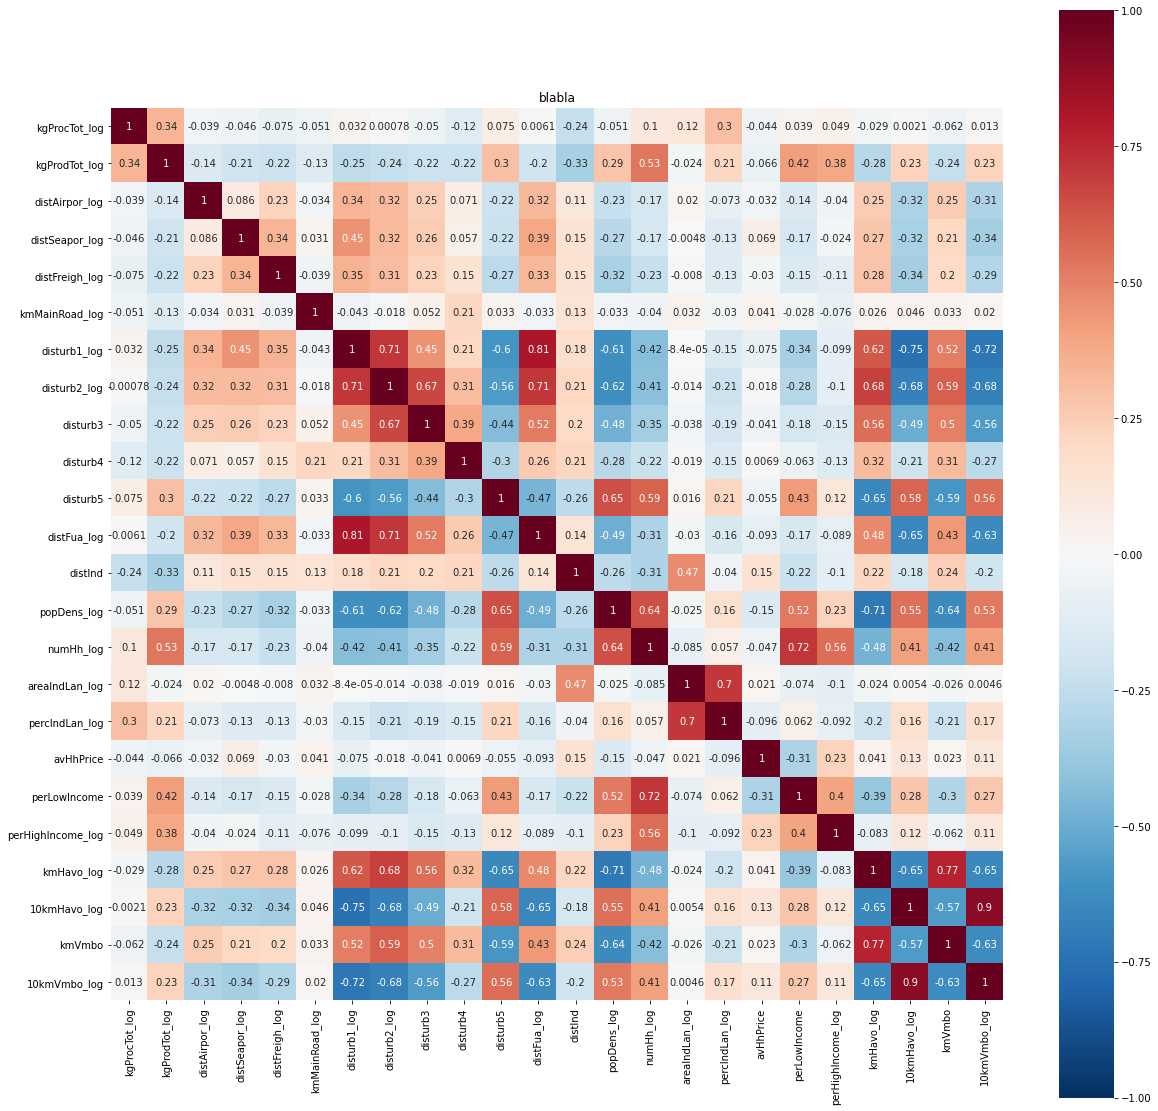

In [107]:
norm = plt.Normalize(-1,1)
fig, ax = plt.subplots(figsize=(20,20))
sn.heatmap(X.corr(), square=True, annot=True, ax=ax, cmap='RdBu_r', norm=norm, cbar=True)
ax.set_title('blabla')
plt.show()

Factor pairs with correlations higher than 0.8: 
* disturb1_log and distfua_log (0.81) - this makes sense, urb1 and fua are both basically urban areas
* 10kmVmbo_log and 10kmHavo_log (0.9) - also makes sense, universities are probs close together 

In [124]:
df = X.drop(columns=['distFua_log', '10kmVmbo_log'])
print('variables (n={}) for factor analysis:'.format(len(df.columns)))
df.columns

variables (n=22) for factor analysis:


Index(['kgProcTot_log', 'kgProdTot_log', 'distAirpor_log', 'distSeapor_log',
       'distFreigh_log', 'kmMainRoad_log', 'disturb1_log', 'disturb2_log',
       'disturb3', 'disturb4', 'disturb5', 'distInd', 'popDens_log',
       'numHh_log', 'areaIndLan_log', 'percIndLan_log', 'avHhPrice',
       'perLowIncome', 'perHighIncome_log', 'kmHavo_log', '10kmHavo_log',
       'kmVmbo'],
      dtype='object')

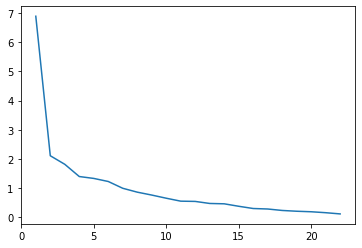

In [102]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer()
fa.fit(df,10)
ev, v = fa.get_eigenvalues()
ev
plt.plot(range(1,df.shape[1]+1),ev)

In [145]:
fa = FactorAnalyzer(4, rotation='varimax') # selects 5 factors 
fa.fit(df)
loads = fa.loadings_
loadMatrix = pd.DataFrame(loads)
loadMatrix.index = df.columns
loadMatrix.style.apply(lambda x: ["background: orange" if abs(v) > 0.4 else "" for v in x], axis = 1)

potential names for factors: 
* 0 - urbanization
* 1 - households
* 2 - industrial land
* 3 - industry prescence

# Trying different options
lag vs nolag, pc4 vs pc2, aggregated vs non-aggregated materials

## lag vs nolag, pc4 vs pc2

In [3]:
%%time
flowTypes = ['all', 'mat', 'mat', 'mat', 'sbiSec', 'sbiSec', 'sbiSec']
flowNames = ['all', '25', '12.8', '12.1', 'C', 'E', 'F']

# lag vs nolag
df_pc4_lag = linearModelStats(df=lma, pc=pc, wds=wds, flowTypes=['all'], flowNames=['all'], lag=True, dropZero=False)
df_pc2_lag = linearModelStats(df=lmaPc2, pc=pc2, wds=wdsPc2, flowTypes=['all'], flowNames=['all'], lag=True, dropZero=False)

# pc4 vs pc2 
df_pc4_nolag = linearModelStats(df=lma, pc=pc, wds=wds, flowTypes=flowTypes, flowNames=flowNames, lag=False, dropZero=False)
df_pc2_nolag = linearModelStats(df=lmaPc2, pc=pc2, wds=wdsPc2, flowTypes=flowTypes, flowNames=flowNames, lag=False, dropZero=False)

Wall time: 2min 38s


In [68]:
df_stats_pc = pd.concat([df_pc4_lag, df_pc2_lag, df_pc4_nolag, df_pc2_nolag]).reset_index(drop=True)
df_stats_pc.drop(columns='params').sort_values(by='r2', ascending=False).head()

flowType flowName                                        ideal_model  \
1       all      all  <statsmodels.regression.linear_model.Regressio...   
9       all      all  <statsmodels.regression.linear_model.Regressio...   
15   sbiSec        F  <statsmodels.regression.linear_model.Regressio...   
10      mat       25  <statsmodels.regression.linear_model.Regressio...   
11      mat     12.8  <statsmodels.regression.linear_model.Regressio...   

          r2         aic         bic pcType  dropzero    lag  n_params  
1   0.997149  265.312656  305.309610    pc2     False   True        16  
9   0.995347  302.616802  322.615279    pc2     False  False         8  
15  0.989659  344.310739  354.309978    pc2     False  False         4  
10  0.953613  479.602991  489.602229    pc2     False  False         4  
11  0.943254  489.126736  501.625784    pc2     False  False         5

Comments on results: 

* pc4 vs pc2
    * R2 - PC2 results in a much higher r2 (0.9 for all flow types), while PC4 results have lower r2 (0.68 for all flows, 0.2-0.3 for other flow types). Maybe because there are less data points for PC2 (n=90 vs n=4000) 
    * params - 
        * the params of PC2 are all space-related factors, probably because, at a larger scale, level of urbanization plays a bigger role on kg received. Many params are distance from a certain kind of land (distubr1, disturb4, distfua...etc) Interestingly, industrial land related params didn't show up, nor did any flow related params.
        * the params of PC4 are a mix of space, people, and flow factors. This includes industrial land, distance from land types, population density related stuff.
* lag vs nolag
    * R2 - including spatial lag exVars didn't significantly improve R2 results, at least for linear models of all flow types. 
    * coefficients 
* zero values? 

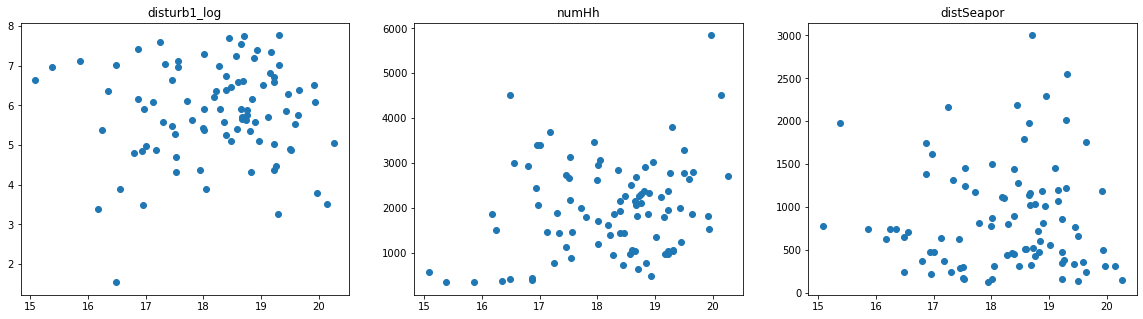

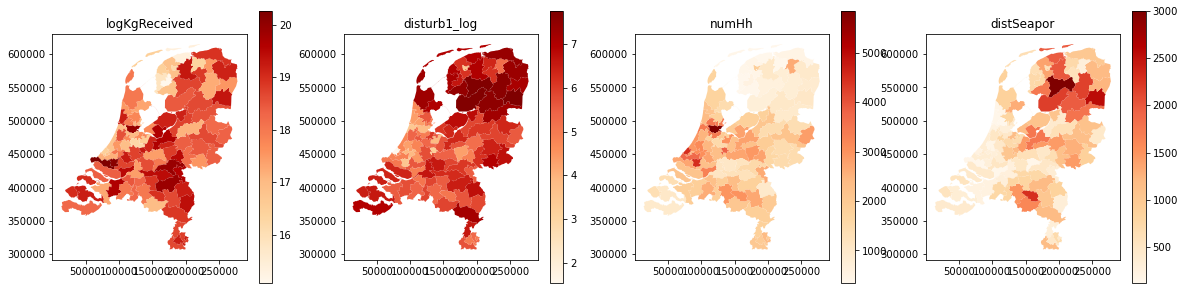

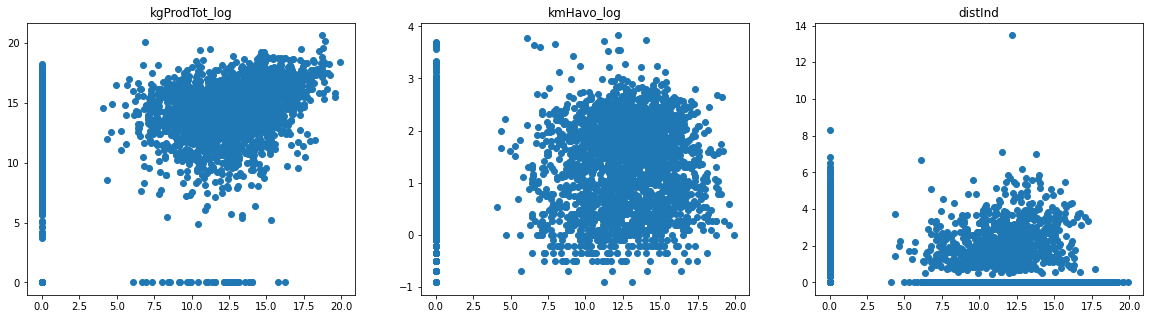

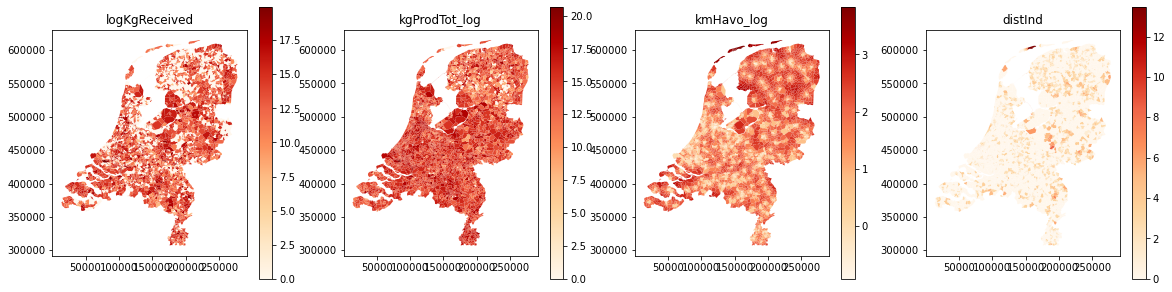

In [11]:
# plotting maps for pc2 data 
y, X = make_yx(df=lmaPc2, pc=pc2, stakeholderType='waste receiver', wds=wdsPc2, lag=False, flowType='all', flowName='all')
plotPc2 = pd.concat([pc2, y, X], axis=1)
# scatter
fig, ax = plt.subplots(1,3,figsize=(5*4,5))
for i,v in enumerate(['disturb1_log', 'numHh', 'distSeapor']): 
    ax[i].scatter(y, X[v])
    ax[i].set_title(v)
plt.show()
# map
fig, ax = plt.subplots(1,4,figsize=(5*4,5))
for i,v in enumerate(['logKgReceived', 'disturb1_log', 'numHh', 'distSeapor']): 
    plotPc2.plot(column=v, cmap='OrRd', legend=True, ax=ax[i])
    ax[i].set_title(v)
plt.show()

# plotting maps for pc4 data 
y, X = make_yx(df=lma, pc=pc, stakeholderType='waste receiver', wds=wds, lag=False, flowType='all', flowName='all')
plotPc4 = pd.concat([pc, y, X], axis=1)
# scatter
fig, ax = plt.subplots(1,3,figsize=(5*4,5))
for i,v in enumerate(['kgProdTot_log', 'kmHavo_log', 'distInd']): 
    ax[i].scatter(y, X[v])
    ax[i].set_title(v)
plt.show()
# map
fig, ax = plt.subplots(1,4,figsize=(5*4,5))
for i,v in enumerate(['logKgReceived', 'kgProdTot_log', 'kmHavo_log', 'distInd']): 
    plotPc4.plot(column=v, cmap='OrRd', legend=True, ax=ax[i])
    ax[i].set_title(v)
plt.show()

## Aggragating material types

In [12]:
%%time

esv = pd.read_excel('../data/classification/ewc_transformation-file.xlsx')
esvMain = esv.groupby(['esvMain', 'esvMainDesc']).sum().reset_index()
esvMain = esvMain[['esvMain', 'esvMainDesc']]
esvMain.esvMain = esvMain.esvMain.astype('str')
gnc = pd.read_feather('../data/classification/gnc_Headings.feather')

lmaMatAgg = lma.copy().reset_index(drop=True)
def matMain(row): 
    if row.matDesc.startswith('ESV'): 
        row.mat = row.mat.split('.')[0]
        if row.mat.startswith('0'): 
            row.mat = row.mat[1:]
        row.matDesc = 'ESV - ' + esvMain[esvMain.esvMain == row.mat].esvMainDesc.values[0]
    elif row.matDesc.startswith('GNC'): 
        try: 
            section = gnc[gnc.gnc == row.mat].section.values[0]
            row.mat = section
            row.matDesc = 'GNC - ' + gnc[gnc.gnc==section].gncDesc.values[0]
        except: 
            row.mat = '--'
            row.matDesc = '--'
    return row
lmaMatAgg = lmaMatAgg.apply(lambda row: matMain(row), axis=1)

Wall time: 25.4 s


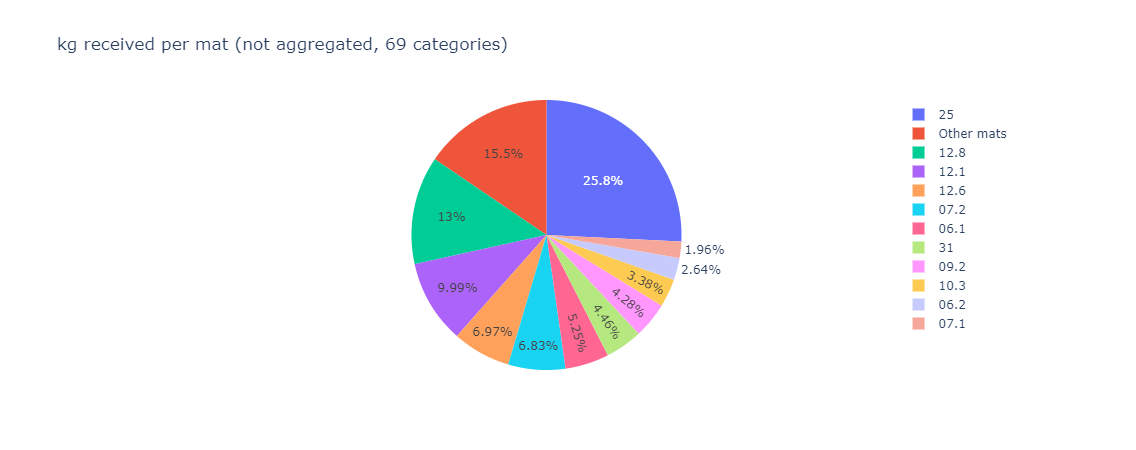

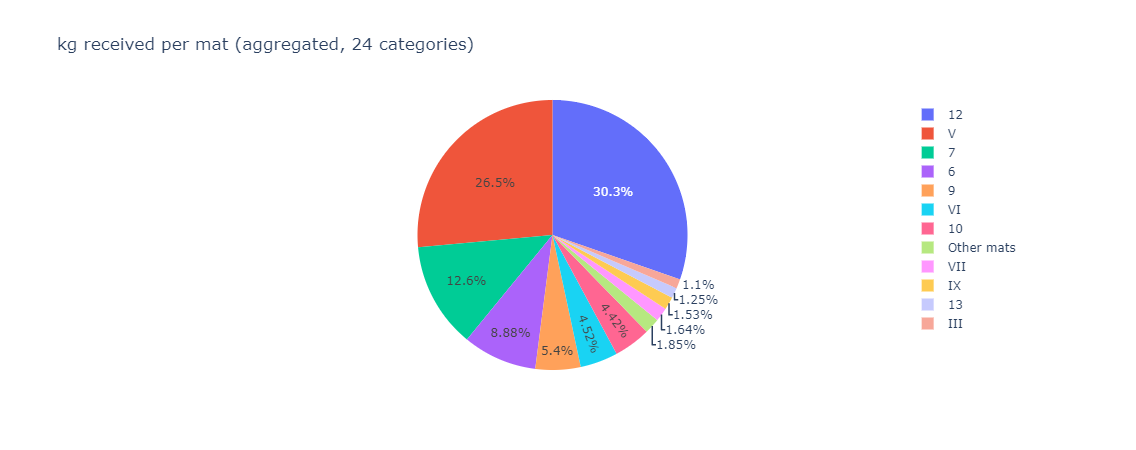

In [13]:
# plot share of material categories 
mat = lma[lma.stakeholderType == 'waste receiver'].groupby(['mat', 'matDesc']).sum().reset_index()
mat = mat.sort_values(by='kg', ascending=False).reset_index(drop=True)
mat.loc[mat['kg'] < mat.loc[10,'kg'], 'mat'] = 'Other mats' # Represent only large countries
import plotly.express as px
fig = px.pie(mat, values='kg', names='mat', title='kg received per mat (not aggregated, {} categories)'.format(len(mat)))
fig.show()

# plot share of aggregated material categories 
matAgg = lmaMatAgg[lmaMatAgg.stakeholderType == 'waste receiver'].groupby(['mat', 'matDesc']).sum().reset_index()
matAgg = matAgg.sort_values(by='kg', ascending=False).reset_index(drop=True)
matAgg.loc[matAgg['kg'] < matAgg.loc[10,'kg'], 'mat'] = 'Other mats' # Represent only large countries
import plotly.express as px
fig = px.pie(matAgg, values='kg', names='mat', title='kg received per mat (aggregated, {} categories)'.format(len(matAgg)))
fig.show()

In [15]:
flowTypes = ['all', 'mat', 'mat', 'mat']
flowNames = ['all', '12', 'V', '7']
df_pc4_nolag_matAgg = linearModelStats(df=lmaMatAgg, pc=pc, wds=wds, flowTypes=flowTypes, flowNames=flowNames, lag=False, dropZero=False)

In [69]:
df_stats_matAgg = pd.concat([df_pc4_nolag_matAgg, df_pc4_nolag])
df_stats_matAgg['matAgg'] = True
df_stats_matAgg.params = df_stats_matAgg.params.map(lambda x: tuple(x))
df_stats_matAgg.drop(columns=['params']).sort_values(by='r2', ascending=False).head()

flowType flowName                                        ideal_model  \
0      all      all  <statsmodels.regression.linear_model.Regressio...   
0      all      all  <statsmodels.regression.linear_model.Regressio...   
1      mat       12  <statsmodels.regression.linear_model.Regressio...   
6   sbiSec        F  <statsmodels.regression.linear_model.Regressio...   
2      mat        V  <statsmodels.regression.linear_model.Regressio...   

         r2           aic           bic pcType  dropzero    lag  n_params  \
0  0.688336  25461.810599  25556.474201    pc4     False  False        15   
0  0.688336  25461.810599  25556.474201    pc4     False  False        15   
1  0.441562  24995.095646  25083.448341    pc4     False  False        14   
6  0.307160  23704.712682  23755.199936    pc4     False  False         8   
2  0.305955  24022.251817  24079.049978    pc4     False  False         9   

   matAgg  
0    True  
0    True  
1    True  
6    True  
2    True

## with vs without zero values

In [22]:
flowTypes = ['all', 'mat', 'mat', 'mat', 'sbiSec', 'sbiSec', 'sbiSec']
flowNames = ['all', '25', '12.8', '12.1', 'C', 'E', 'F']

In [28]:
%%time
df_dropZero = linearModelStats(df=lma, pc=pc, wds=wds, flowTypes=flowTypes, flowNames=flowNames, lag=False, dropZero=True)

Wall time: 16.7 s


In [70]:
df_stats_dropZero = pd.concat([df_dropZero, df_pc4_nolag])
df_stats_dropZero.drop(columns=['params']).sort_values(by='r2', ascending=False).head()

flowType flowName                                        ideal_model  \
3      mat     12.1  <statsmodels.regression.linear_model.Regressio...   
0      all      all  <statsmodels.regression.linear_model.Regressio...   
1      mat       25  <statsmodels.regression.linear_model.Regressio...   
2      mat     12.8  <statsmodels.regression.linear_model.Regressio...   
5   sbiSec        E  <statsmodels.regression.linear_model.Regressio...   

         r2           aic           bic pcType  dropzero    lag  n_params  
3  0.968369   2688.164144   2705.778441    pc4      True  False         4  
0  0.966045  10815.620093  10855.979076    pc4      True  False         7  
1  0.965086   3627.795336   3651.212141    pc4      True  False         5  
2  0.961247   2598.748187   2629.093567    pc4      True  False         7  
5  0.958781   1082.312334   1095.976736    pc4      True  False         4

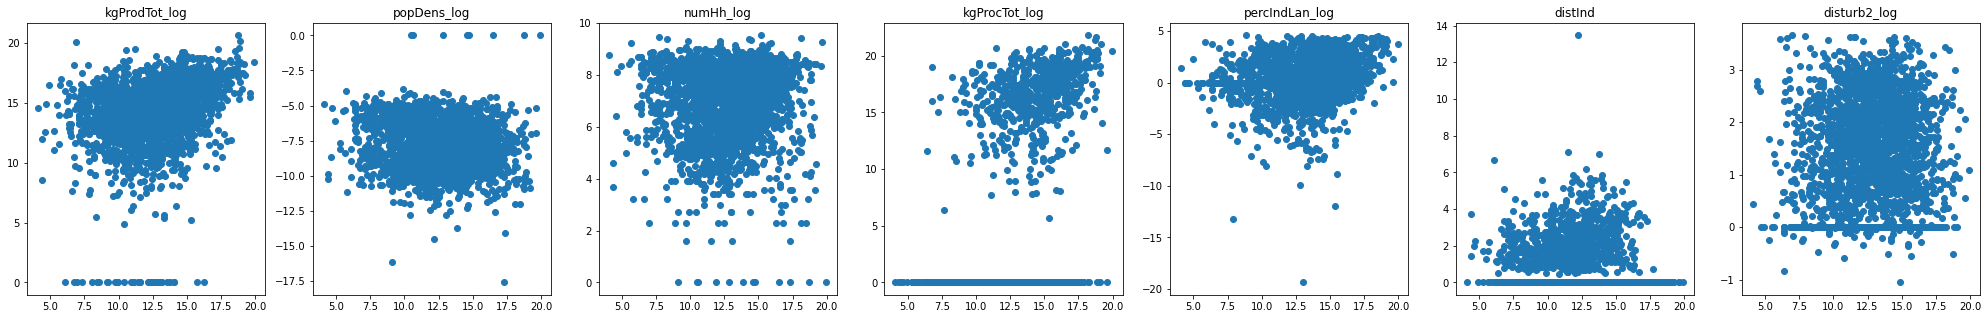

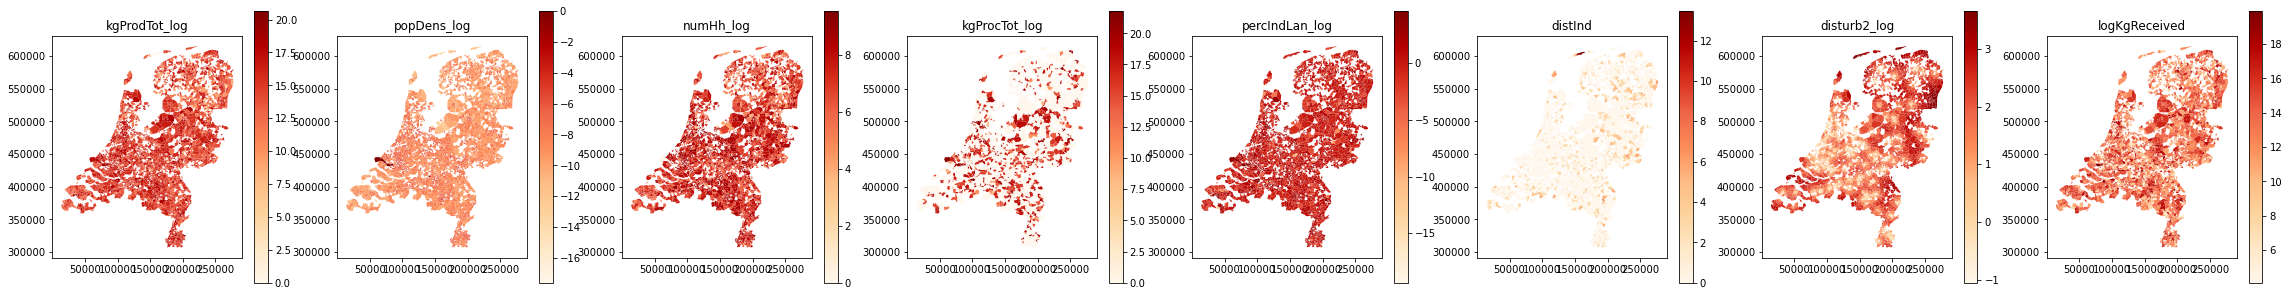

In [30]:
# scatterplots of params 
y, X = make_yx(df=lma, pc=pc, wds=wds, stakeholderType='waste receiver', flowType='all', flowName='all', lag=False)
X = X[y>0]
pc_dropzero = pc[y>0]
y = y[y>0]
params = list(df_dropZero.loc[0,'ideal_model'].params.index)

# scatter
fig, ax = plt.subplots(1,len(params),figsize=(5*len(params),5))
for i,v in enumerate(params): 
    ax[i].scatter(y, X[v])
    ax[i].set_title(v)
plt.show()

# map
map_dropzero = pd.concat([pc_dropzero, y, X], axis=1)
fig, ax = plt.subplots(1,len(params)+1,figsize=(5*(len(params)+1),5))
params.append('logKgReceived')
for i,v in enumerate(params): 
    map_dropzero.plot(column=v, cmap='OrRd', legend=True, ax=ax[i])
    ax[i].set_title(v)
plt.show()

In [67]:
df_stats_all = pd.concat([df_stats_pc, df_stats_matAgg, df_stats_dropZero]).reset_index(drop=True)
df_stats_all.params = df_stats_all.params.map(lambda x: tuple(x))
df_stats_all.drop_duplicates(inplace=True)
df_stats_all = df_stats_all.drop(columns='params').sort_values(by='r2', ascending=False).reset_index(drop=True)
df_stats_all.fillna(False, inplace=True)
df_stats_all

flowType flowName                                        ideal_model  \
0       all      all  <statsmodels.regression.linear_model.Regressio...   
1       all      all  <statsmodels.regression.linear_model.Regressio...   
2    sbiSec        F  <statsmodels.regression.linear_model.Regressio...   
3       mat     12.1  <statsmodels.regression.linear_model.Regressio...   
4       all      all  <statsmodels.regression.linear_model.Regressio...   
5       mat       25  <statsmodels.regression.linear_model.Regressio...   
6       mat     12.8  <statsmodels.regression.linear_model.Regressio...   
7    sbiSec        E  <statsmodels.regression.linear_model.Regressio...   
8    sbiSec        F  <statsmodels.regression.linear_model.Regressio...   
9       mat       25  <statsmodels.regression.linear_model.Regressio...   
10      mat     12.8  <statsmodels.regression.linear_model.Regressio...   
11   sbiSec        C  <statsmodels.regression.linear_model.Regressio...   
12   sbiSec        C  <statsmodels.regression.linear_model.Regressio...   
13      mat     12.1  <statsmodels.regression.linear_model.Regressio...   
14   sbiSec        E  <statsmodels.regression.linear_model.Regressio...   
15      all      all  <statsmodels.regression.linear_model.Regressio...   
16      all      all  <statsmodels.regression.linear_model.Regressio...   
17      all      all  <statsmodels.regression.linear_model.Regressio...   
18      all      all  <statsmodels.regression.linear_model.Regressio...   
19      mat       12  <statsmodels.regression.linear_model.Regressio...   
20   sbiSec        F  <statsmodels.regression.linear_model.Regressio...   
21   sbiSec        F  <statsmodels.regression.linear_model.Regressio...   
22      mat        V  <statsmodels.regression.linear_model.Regressio...   
23      mat       25  <statsmodels.regression.linear_model.Regressio...   
24      mat       25  <statsmodels.regression.linear_model.Regressio...   
25      mat        7  <statsmodels.regression.linear_model.Regressio...   
26      mat     12.8  <statsmodels.regression.linear_model.Regressio...   
27      mat     12.8  <statsmodels.regression.linear_model.Regressio...   
28      mat     12.1  <statsmodels.regression.linear_model.Regressio...   
29      mat     12.1  <statsmodels.regression.linear_model.Regressio...   
30   sbiSec        E  <statsmodels.regression.linear_model.Regressio...   
31   sbiSec        E  <statsmodels.regression.linear_model.Regressio...   
32   sbiSec        C  <statsmodels.regression.linear_model.Regressio...   
33   sbiSec        C  <statsmodels.regression.linear_model.Regressio...   

          r2           aic           bic pcType  dropzero    lag  n_params  \
0   0.997149    265.312656    305.309610    pc2     False   True        16   
1   0.995347    302.616802    322.615279    pc2     False  False         8   
2   0.989659    344.310739    354.309978    pc2     False  False         4   
3   0.968369   2688.164144   2705.778441    pc4      True  False         4   
4   0.966045  10815.620093  10855.979076    pc4      True  False         7   
5   0.965086   3627.795336   3651.212141    pc4      True  False         5   
6   0.961247   2598.748187   2629.093567    pc4      True  False         7   
7   0.958781   1082.312334   1095.976736    pc4      True  False         4   
8   0.956423   3784.244879   3798.332275    pc4      True  False         3   
9   0.953613    479.602991    489.602229    pc2     False  False         4   
10  0.943254    489.126736    501.625784    pc2     False  False         5   
11  0.936551   1757.668606   1765.326497    pc4      True  False         2   
12  0.929210    506.162345    511.161964    pc2     False  False         2   
13  0.917650    519.047742    526.547171    pc2     False  False         3   
14  0.904442    526.028532    538.527580    pc2     False  False         5   
15  0.698721  25325.950347  25433.235762    pc4     False   True        17   
16  0.688336  25461.810599  25556.474201    pc4    

# Code dump

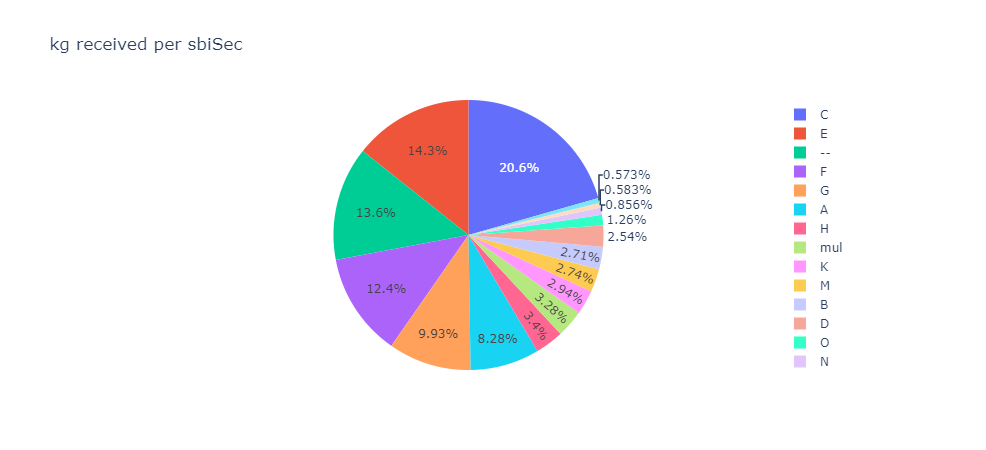

In [4]:
temp = lma[lma.stakeholderType == 'waste receiver'][['sbiSec', 'kg']]
temp = temp.groupby('sbiSec').sum().reset_index().sort_values(by='kg', ascending=False)
temp.loc[temp['kg'] < 5.e7, 'sbiSec'] = 'Other sbiSec' # Represent only large countries
import plotly.express as px
fig = px.pie(temp, values='kg', names='sbiSec', title='kg received per sbiSec')
fig.show()

### 2nd try: without spatial lag, largest flows by geographical coverage

In [11]:
flowTypes = ['all', 'mat', 'mat', 'mat', 'sbiSec', 'sbiSec', 'sbiSec']
flowNames = ['all', '25', '09.2', '31', 'A', 'F', 'N']
lag = False

In [12]:
%%time

r2s = []
aics = []
bics = []
ideal_models = []

for i in range(len(flowTypes)): 
    y, X = make_yx(df=lma, stakeholderType='waste receiver', wds=wds, lag=lag, flowType=flowTypes[i], flowName=flowNames[i])
    models = models_fwd(y, X, plot=False)
    ideal_model = models.loc[models.bic.idxmin(), "model"]
    ideal_models.append(ideal_model)
    r2s.append(ideal_model.rsquared_adj)
    aics.append(ideal_model.aic)
    bics.append(ideal_model.bic)

df_stats = pd.DataFrame({
    'flowType': flowTypes, 
    'flowName': flowNames, 
    'ideal_model': ideal_models, 
    'r2': r2s, 
    'aic': aics, 
    'bic': bics
})

df_stats['lag'] = False
df_stats['weightOrGeo'] = 'geo'

df_stats_2 = df_stats.copy()

Wall time: 23.1 s


In [13]:
df_stats_2

flowType flowName                                        ideal_model  \
0      all      all  <statsmodels.regression.linear_model.Regressio...   
1      mat       25  <statsmodels.regression.linear_model.Regressio...   
2      mat     09.2  <statsmodels.regression.linear_model.Regressio...   
3      mat       31  <statsmodels.regression.linear_model.Regressio...   
4   sbiSec        A  <statsmodels.regression.linear_model.Regressio...   
5   sbiSec        F  <statsmodels.regression.linear_model.Regressio...   
6   sbiSec        N  <statsmodels.regression.linear_model.Regressio...   

         r2           aic           bic    lag weightOrGeo  
0  0.688336  25461.810599  25556.474201  False         geo  
1  0.305949  23995.093167  24051.891328  False         geo  
2  0.294322  22730.459347  22825.122949  False         geo  
3  0.258937  23232.283651  23308.014533  False         geo  
4  0.363951  24256.992922  24370.589243  False         geo  
5  0.307160  23704.712682  23755.199936  False         geo  
6  0.194852  21424.690902  21475.178156  False         geo

In [14]:
df_stats_all = pd.concat([df_stats_1, df_stats_2]).reset_index(drop=True)
df_stats_all

flowType flowName                                        ideal_model  \
0       all      all  <statsmodels.regression.linear_model.Regressio...   
1       mat       25  <statsmodels.regression.linear_model.Regressio...   
2       mat     12.8  <statsmodels.regression.linear_model.Regressio...   
3       mat     12.1  <statsmodels.regression.linear_model.Regressio...   
4    sbiSec        C  <statsmodels.regression.linear_model.Regressio...   
5    sbiSec        E  <statsmodels.regression.linear_model.Regressio...   
6    sbiSec        F  <statsmodels.regression.linear_model.Regressio...   
7       all      all  <statsmodels.regression.linear_model.Regressio...   
8       mat       25  <statsmodels.regression.linear_model.Regressio...   
9       mat     09.2  <statsmodels.regression.linear_model.Regressio...   
10      mat       31  <statsmodels.regression.linear_model.Regressio...   
11   sbiSec        A  <statsmodels.regression.linear_model.Regressio...   
12   sbiSec        F  <statsmodels.regression.linear_model.Regressio...   
13   sbiSec        N  <statsmodels.regression.linear_model.Regressio...   

          r2           aic           bic    lag weightOrGeo  
0   0.688336  25461.810599  25556.474201  False      weight  
1   0.305949  23995.093167  24051.891328  False      weight  
2   0.263904  22640.032559  22684.208907  False      weight  
3   0.260000  23151.569689  23202.056943  False      weight  
4   0.243274  20998.137694  21029.692227  False      weight  
5   0.243787  19562.028178  19599.893618  False      weight  
6   0.307160  23704.712682  23755.199936  False      weight  
7   0.688336  25461.810599  25556.474201  False         geo  
8   0.305949  23995.093167  24051.891328  False         geo  
9   0.294322  22730.459347  22825.122949  False         geo  
10  0.258937  23232.283651  23308.014533  False         geo  
11  0.363951  24256.992922  24370.589243  False         geo  
12  0.307160  23704.712682  23755.199936  False         geo  
13  0.194852  21424.690902  21475.178156  False         geo

In [20]:
print(df_stats_all.loc[0, 'ideal_model'].summary())

                                 OLS Regression Results                                
Dep. Variable:          logKgReceived   R-squared (uncentered):                   0.689
Model:                            OLS   Adj. R-squared (uncentered):              0.688
Method:                 Least Squares   F-statistic:                              600.0
Date:                Fri, 01 Oct 2021   Prob (F-statistic):                        0.00
Time:                        09:52:14   Log-Likelihood:                         -12716.
No. Observations:                4068   AIC:                                  2.546e+04
Df Residuals:                    4053   BIC:                                  2.556e+04
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## Comments on results
* r2 - general
    * r2 is lower since removing 'too obvious' flow variables like total kg received regardless of industry, and kg received within distance bands. r2 used to be 0.97, now it's 0.68 for all flows, which is more reasonable. For specific flows, it's even lower, ranging from 0.2 - 0.3. 
    * r2 for all flows (regardless of industry, material type) is far higher than r2 for specific flows (0.68 vs 0.2-0.3). Does this mean something, or is this another case of those pesky zero values skewing the results? If it means something, it could mean that...? 
* r2 - more geo vs weight, material vs industry
    * r2 values are generally higher when top3 flows are chosen by geographical spread rather than weight. This is not surprising - from esda notebook, we saw that higher geographical spread = higher moran's I = higher spatial pattern = more likely to be affected by geographical factors. 
    * there doesn't seem to be a huge difference in r2 for material vs industry categorization. But I suspect this will change when we're looking for more than top3, because the Moran's I for top3 materials vs industry is pretty similar, but not top10 
    * interestingly, 'N' (Rental of movable property and other business services) has a high Moran's I than 'C' (manufacturing) and 'E' (Extraction and distribution of water; waste and wastewater management and remediation), but has a lower r2 than them.  
* explanatory variables
    * there are currently lots of explanatory variables, 26 if there are no spatial lag, and 104 if there are. This might be too much? 
    * ideal number of explanatory variables tend to be: 
    * explanatory variables that consistantly show up are: 

## Limitations
* tons of zero values could lead to inaccurate results
* a lot of explanatory variables but still relatively low r2, so there isn't a single factor that has a great effect on kg received, rather it is a combination. But even with the combination, not a lot of explained 
* not sure if the r2 is low or not, depends on the discipline I suppose. Looking at Bardia's paper on energy consumption, his OLS r2 = 0.67, and GWR r2 = 0.78. So I would say that my linear model for all the material flows is good, but maybe not for specific material flows. Two ways to bump up the r2 would be to broaden the flow categorizations, or aggregate data into 2-digit postcodes (n=90). 

## Next steps 
* pick top 3 based on moran's I (although that's probs quite similar to geo) 
* factor analysis to reduce number of variales 
* logistic regression?? 
* get rid of zero values

### 3rd try: with spatial lag, largest flows by weight

In [299]:
flowTypes = ['mat', 'sbiSec']
flowNames = ['25', 'C']

In [300]:
%%time
df_stats = make_linear_model_for_flows(flowTypes, flowNames, lag=True)
linear_model_stats = linear_model_stats.append(df_stats)

Wall time: 4min 22s


### 4th try: with spatial lag, largest flows by geographical coverage

In [280]:
flowTypes = ['all', 'mat', 'mat', 'mat', 'sbiSec', 'sbiSec', 'sbiSec']
flowNames = ['all', '25', '09.2', '31', 'A', 'F', 'N']

In [281]:
%%time
df_stats = make_linear_model_for_flows(flowTypes, flowNames, lag=True)
linear_model_stats = linear_model_stats.append(df_stats)

Wall time: 20.2 s


## Display all model stats

In [306]:
linear_model_stats

flowType flowName                                        ideal_model  \
0      all      all  <statsmodels.regression.linear_model.Regressio...   
1      mat       25  <statsmodels.regression.linear_model.Regressio...   
2      mat     12.8  <statsmodels.regression.linear_model.Regressio...   
3      mat     12.1  <statsmodels.regression.linear_model.Regressio...   
4   sbiSec        C  <statsmodels.regression.linear_model.Regressio...   
5   sbiSec        E  <statsmodels.regression.linear_model.Regressio...   
6   sbiSec        F  <statsmodels.regression.linear_model.Regressio...   

         r2           aic           bic  lag weightOrKg  
0  0.381570  23540.737948  23692.199710  0.0     weight  
1  0.385008  23520.047548  23684.131124  0.0     weight  
2  0.385008  23520.047548  23684.131124  0.0     weight  
3  0.385008  23520.047548  23684.131124  0.0     weight  
4  0.385008  23520.047548  23684.131124  0.0     weight  
5  0.385008  23520.047548  23684.131124  0.0     weight  
6  0.385008  23520.047548  23684.131124  0.0     weight